In [1]:
!pip install sagemaker ipywidgets --upgrade --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.5.0 requires botocore<1.29.77,>=1.29.76, but you have botocore 1.29.149 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [7]:
import sagemaker, boto3, json

aws_role = 'arn:aws:iam::950206571262:role/service-role/AmazonSageMaker-ExecutionRole-20230502T011199'
aws_region = "us-west-2"
sess = sagemaker.Session()

aws_role, sess

('arn:aws:iam::950206571262:role/service-role/AmazonSageMaker-ExecutionRole-20230502T011199',
 <sagemaker.session.Session at 0x2950b0810>)

In [4]:

from ipywidgets import Dropdown

# download JumpStart model_manifest file.
boto3.client("s3").download_file(
    f"jumpstart-cache-prod-{aws_region}", "models_manifest.json", "models_manifest.json"
)
with open("models_manifest.json", "rb") as json_file:
    model_list = json.load(json_file)

# filter-out all the Text Embedding models from the manifest list.
text_embedding_models = []
for model in model_list:
    model_id = model["model_id"]
    if "-tcembedding-" in model_id and model_id not in text_embedding_models:
        text_embedding_models.append(model_id)

# display the model-ids in a dropdown to select a model for inference.
model_dropdown = Dropdown(
    options=text_embedding_models,
    value="tensorflow-tcembedding-bert-en-uncased-L-10-H-128-A-2-2",
    description="Select a model",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)



In [5]:
display(model_dropdown)

Dropdown(description='Select a model', index=4, layout=Layout(width='max-content'), options=('mxnet-tcembeddin…

In [6]:
# model_version="*" fetches the latest version of the model
model_id, model_version = model_dropdown.value, "*"

In [8]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base


endpoint_name = name_from_base(f"jumpstart-example-infer-{model_id}")

inference_instance_type = "ml.p2.xlarge"

# Retrieve the inference docker container uri. This is the base Tensorflow container image for the default model above.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)

# Retrieve the inference script uri. This includes all dependencies and scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="inference"
)


# Retrieve the model uri. This includes the model and model parameters.
model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="inference"
)


# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    model_data=model_uri,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
)

# deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)



-------!

In [9]:
def query(model_predictor, text):
    """Query the model predictor."""

    encoded_text = text.encode("utf-8")

    query_response = model_predictor.predict(
        encoded_text,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return the embedding."""

    model_predictions = json.loads(query_response)
    translation_text = model_predictions["embedding"]
    return translation_text


In [13]:
newline, bold, unbold = "\n", "\033[1m", "\033[0m"

input_text = "astonishing ... ( frames ) profound ethical and philosophical questions in the form of dazzling pop entertainment"


query_response = query(model_predictor, input_text)

embedding = parse_response(query_response)

print(
    f"{bold}Inference{unbold}:{newline}"
    f"{bold}Input text sentence{unbold}: '{input_text}'{newline}"
    f"{bold}The first 5 elements of sentence embedding{unbold}: {embedding[:5]}{newline}"
    f"{bold}Sentence embedding size{unbold}: {len(embedding)}{newline}"
)


Inference:
Input text sentence: 'astonishing ... ( frames ) profound ethical and philosophical questions in the form of dazzling pop entertainment'
The first 5 elements of sentence embedding: [-0.893901587, 0.941231728, -0.0368938707, -0.908408642, -0.987246156]
Sentence embedding size: 128



In [25]:
products = ["milk from coconut.",
            "milk with fruits.",
            "fresh Strawberries."]

asins = {"B0082WMM7C":["STRAWBERRIES GROWN FRESH PRODUCE FRUIT VEGETABLES PER POUND "],
         "B0BWBP66TV":["Starbucks Pink & Paradise Drink, 2 Flavor Variety Pack, Coconut Milk, 14oz Bottles (12 Pack) ."],
         "B07PBFNYXV":["Califia Farms - Oat Barista Blend Oat Milk, 32 Oz (Pack of 6), Shelf Stable, Dairy Free, Plant Based, Vegan, Gluten Free, Non GMO, High Calcium, Milk Frother, Creamer, Oatmilk."],
         "B074J6FD4L":["365 by Whole Foods Market, Milk Whole Organic, 128 Fl Oz."],
         "B09GW6Y751":["Fusion Select Instant Boba - No-Cook Instant Tapioca Pearls for Bubble Tea Drinks, Hot or Cold Sweet Milk Beverage - Microwave or Heat With Boiling Water"],
         "B0891Y55CF":["Relative Foods Organic Brown Sugar, 3 pound resealable bag. Blended and packaged in our allergen free, gluten free facility. Certified gluten free"],
         "B0BQKSPHMQ":["Dried Apple Slices, Dehydrated Spiced Apple, Organic and Naturally Dried, Cocktail Garnish - All Natural Garnishes (25 Slices) "],
         "B07RBWSP8Z":["Binggrae Variety Banana, Strawberry, Melon Flavored Milk Drink 6 Packs"],
         "B0861DLNRJ":["Nutristore Freeze Dried Strawberries | 100% Natural, Healthy Fruit Snacks Bulk | Premium Quality & Crispy Fresh Taste | Emergency Survival Food Supply | #10 Can | 23 Servings | 25 Year Shelf Life"]
        }

desc_to_asin = {desc[0]:asin for asin,desc in asins.items()}

for asin in asins:
    products.append(asins[asin][0])

products, desc_to_asin


(['milk from coconut.',
  'milk with fruits.',
  'fresh Strawberries.',
  'STRAWBERRIES GROWN FRESH PRODUCE FRUIT VEGETABLES PER POUND ',
  'Starbucks Pink & Paradise Drink, 2 Flavor Variety Pack, Coconut Milk, 14oz Bottles (12 Pack) .',
  'Califia Farms - Oat Barista Blend Oat Milk, 32 Oz (Pack of 6), Shelf Stable, Dairy Free, Plant Based, Vegan, Gluten Free, Non GMO, High Calcium, Milk Frother, Creamer, Oatmilk.',
  '365 by Whole Foods Market, Milk Whole Organic, 128 Fl Oz.',
  'Fusion Select Instant Boba - No-Cook Instant Tapioca Pearls for Bubble Tea Drinks, Hot or Cold Sweet Milk Beverage - Microwave or Heat With Boiling Water',
  'Relative Foods Organic Brown Sugar, 3 pound resealable bag. Blended and packaged in our allergen free, gluten free facility. Certified gluten free',
  'Dried Apple Slices, Dehydrated Spiced Apple, Organic and Naturally Dried, Cocktail Garnish - All Natural Garnishes (25 Slices) ',
  'Binggrae Variety Banana, Strawberry, Melon Flavored Milk Drink 6 Packs

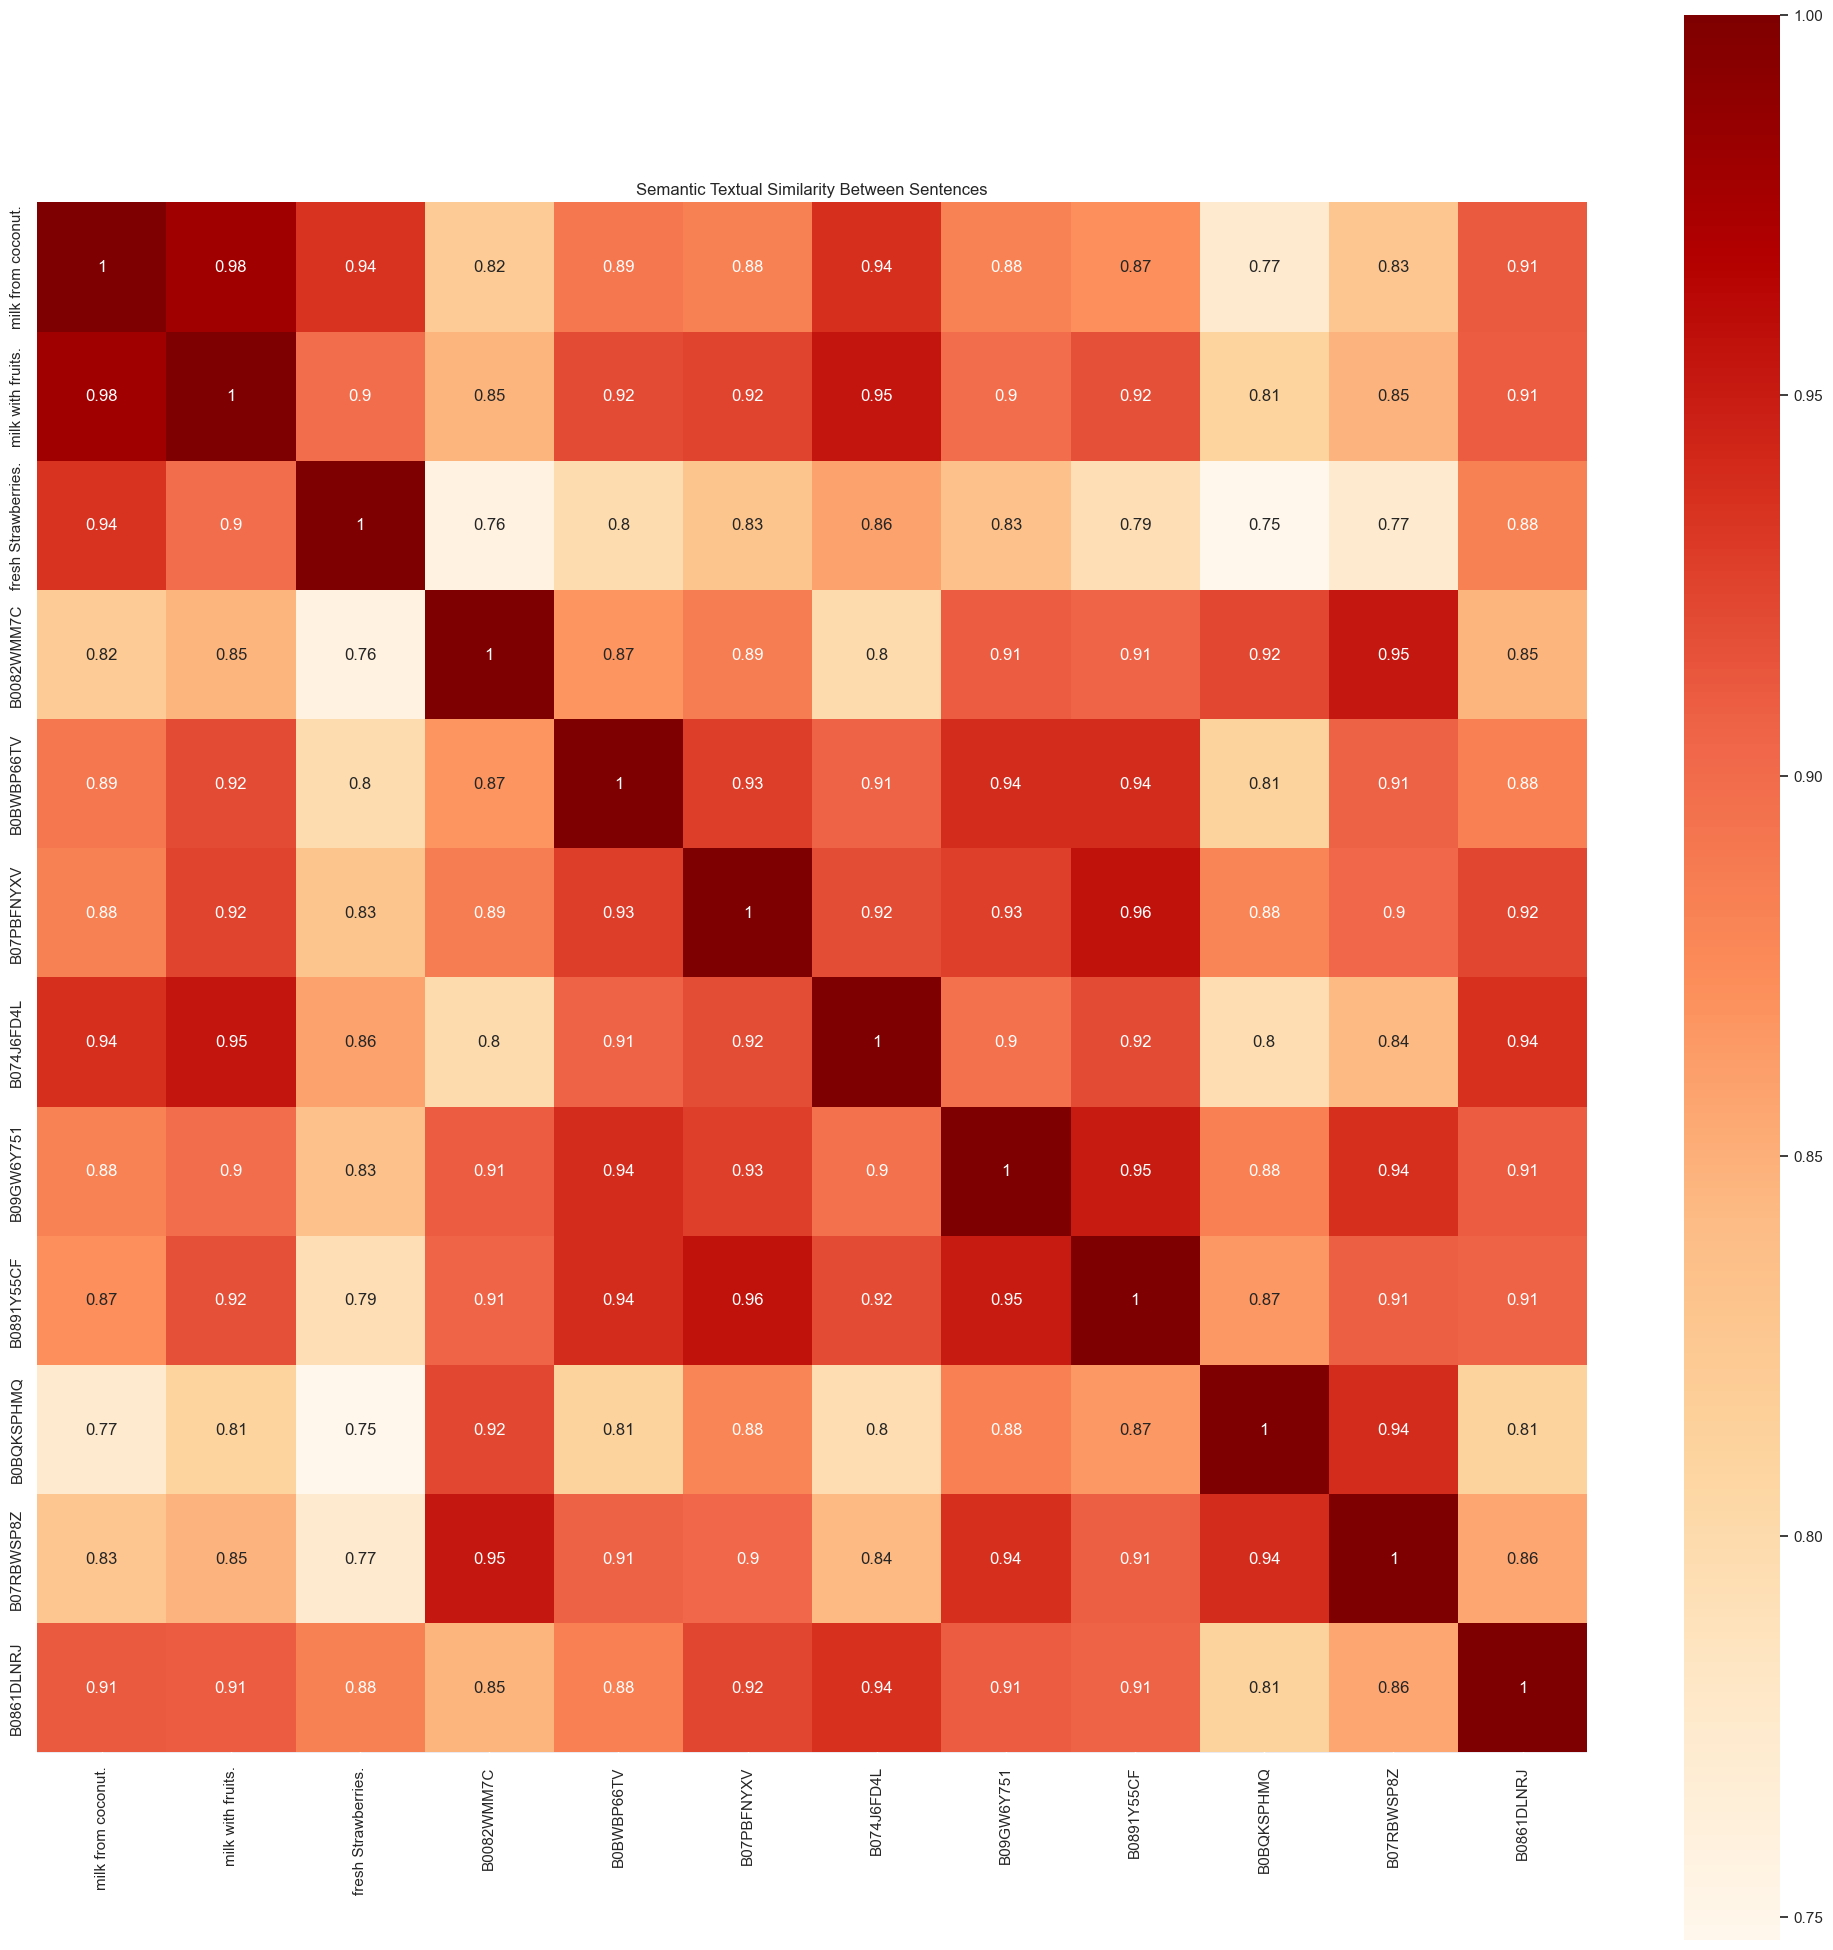

In [33]:
import numpy as np
import seaborn as sns
from sklearn.preprocessing import normalize


def plot_similarity_heatmap(text_labels, embeddings, rotation):

    text_labels = [desc_to_asin[label] if desc_to_asin.get(label) else label for label in text_labels]

    """Takes sentences, embeddings and rotation as input and plot similarity heat map.

    Args:
      text_labels: a list of sentences to compute semantic textual similarity search.
      embeddings: a list of embedding vectors, each of which corresponds to a sentence.
      rotation: rotation used for display of the text_labels.
    """
    inner_product = np.inner(embeddings, embeddings)
    sns.set(font_scale=1.1)
    sns.set (rc = {'figure.figsize':(25, 25)})
    graph = sns.heatmap(
        inner_product,
        annot=inner_product,
        xticklabels=text_labels,
        yticklabels=text_labels,
        vmin=np.min(inner_product),
        vmax=1,
        cmap="OrRd",
        square=True
    )
    graph.set_xticklabels(text_labels, rotation=rotation)
    graph.set_title("Semantic Textual Similarity Between Sentences")


sentences = [
    # Pets
    "Your dog is so cute.",
    "How cute your dog is!",
    "You have such a cute dog!",
    # Cities in the US
    "New York City is the place where I work.",
    "I work in New York City.",
    # Color
    "What color do you like the most?",
    "What is your favourite color?",
]

embeddings = []

for sentence in products:
    query_response = query(model_predictor, sentence)
    embedding = parse_response(query_response)
    embeddings.append(embedding)

embeddings = normalize(np.array(embeddings), axis=1)  # normalization before inner product
plot_similarity_heatmap(products, embeddings, 90)


In [28]:
desc_to_asin

{'STRAWBERRIES GROWN FRESH PRODUCE FRUIT VEGETABLES PER POUND ': 'B0082WMM7C',
 'Starbucks Pink & Paradise Drink, 2 Flavor Variety Pack, Coconut Milk, 14oz Bottles (12 Pack) .': 'B0BWBP66TV',
 'Califia Farms - Oat Barista Blend Oat Milk, 32 Oz (Pack of 6), Shelf Stable, Dairy Free, Plant Based, Vegan, Gluten Free, Non GMO, High Calcium, Milk Frother, Creamer, Oatmilk.': 'B07PBFNYXV',
 '365 by Whole Foods Market, Milk Whole Organic, 128 Fl Oz.': 'B074J6FD4L',
 'Fusion Select Instant Boba - No-Cook Instant Tapioca Pearls for Bubble Tea Drinks, Hot or Cold Sweet Milk Beverage - Microwave or Heat With Boiling Water': 'B09GW6Y751',
 'Relative Foods Organic Brown Sugar, 3 pound resealable bag. Blended and packaged in our allergen free, gluten free facility. Certified gluten free': 'B0891Y55CF',
 'Dried Apple Slices, Dehydrated Spiced Apple, Organic and Naturally Dried, Cocktail Garnish - All Natural Garnishes (25 Slices) ': 'B0BQKSPHMQ',
 'Binggrae Variety Banana, Strawberry, Melon Flavored 